# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
#V4 With Conv 3D and ImageNet with LSTM
# Batch-16

In [ ]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/data/RNN/Project_data.zip','r') as zip:
   zip.extractall()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 16

In [ ]:
def crop_and_resize_image(image, height , width):
  image = resize(image, (height, width), anti_aliasing=True)
  return image/255.0

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
import random

# Keeping more samples near to the mean where the signature will have more data
# Keeping less samples with start and End

def random_bellcurve_numbers(X, Y, N, deviation):
    mean = (X + Y) / 2  # Calculate the mean
    M = int(N * 0.7)
    K = (Y - X) * deviation
    numbers = random.sample(range(int(mean - K), int(mean + K)), M)  # Choose M numbers near the mean
    remaining = N - M # Remainig Numbers
    numbers += random.sample(range(X, int(mean - K)), remaining // 2)
    numbers += random.sample(range(int(mean + K), Y), remaining - (remaining // 2))
    numbers.sort()

    return numbers

In [ ]:
NUM_IMAGE_FOR_TRAINING = 20

def createImageTensor():
    img_idx = random_bellcurve_numbers(0,30,NUM_IMAGE_FOR_TRAINING,0.3)
    return [img_idx, 120, 120, 3]

img_tensor = createImageTensor()
print ('# img_tensor =', img_tensor)


# img_tensor = [[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 25, 28, 29], 120, 120, 3]


In [ ]:
def getBatchData(source_path, t, batch, batch_size):
      #img_idx = #create a list of image numbers you want to use for a particular video
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

    print ('# batch =', batch, "X = ",x,"Y = ",y,"Z = ",z)


    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            batch_data[folder,idx,:,:,0] = crop_and_resize_image(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = crop_and_resize_image(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = crop_and_resize_image(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [ ]:
def generator(source_path, folder_list, batch_size):
    while True:
            t = np.random.permutation(folder_list)
            num_batches = int(len(folder_list)/batch_size)
            batch = 0
            for batch in range(num_batches): # we iterate over the number of batches
                print('batch =',batch ,'num_batches =',num_batches)
                print('Folder Length =',len(folder_list),'batch_size =',batch_size)
                yield getBatchData(source_path, t, batch, batch_size)
            if len(folder_list)%batch_size != 0:
                batch_size = len(folder_list)%batch_size
                yield getBatchData(source_path, t, batch, batch_size)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

batch = 0 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 0 X =  20 Y =  120 Z =  120


<ipython-input-40-47f5ab03b91e>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


(16, 20, 120, 120, 3)
batch = 0 num_batches = 6
Folder Length = 100 batch_size = 16
# batch = 0 X =  20 Y =  120 Z =  120
(16, 20, 120, 120, 3)


In [ ]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Conv2D,MaxPool2D,Dropout


#write your model here
## CNN + RNN or conv3D

## Using Conv 3D
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

model = conv3D()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_8 (Activation)   (None, 10, 60, 60, 32)   

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_8 (Activation)   (None, 10, 60, 60, 32)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model1_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


<ipython-input-53-096c3bdf876e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-40-47f5ab03b91e>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


batch = 2 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 2 X =  20 Y =  120 Z =  120
Epoch 1/10
batch = 3 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 3 X =  20 Y =  120 Z =  120
 1/42 [..............................] - ETA: 12s - loss: 1.3385 - categorical_accuracy: 0.6250batch = 4 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 4 X =  20 Y =  120 Z =  120
 2/42 [>.............................] - ETA: 1:19 - loss: 1.9748 - categorical_accuracy: 0.4375batch = 5 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 5 X =  20 Y =  120 Z =  120
 3/42 [=>............................] - ETA: 1:24 - loss: 1.9239 - categorical_accuracy: 0.3958batch = 6 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 6 X =  20 Y =  120 Z =  120
 4/42 [=>............................] - ETA: 1:18 - loss: 1.8759 - categorical_accuracy: 0.3906batch = 7 num_batches = 41
Folder Length = 663 batch_size = 16
# batch = 7 X =  20 Y =  120 Z =  120


In [81]:
import matplotlib.pyplot as plt
from statistics import mean

def PlotModelHistory(history):
    print(history.history.keys())
    # Accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    print("Training Avg Accuracy", mean(history.history['categorical_accuracy']))
    print("Validaiton Avg Accuracy", mean(history.history['val_categorical_accuracy']))



dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


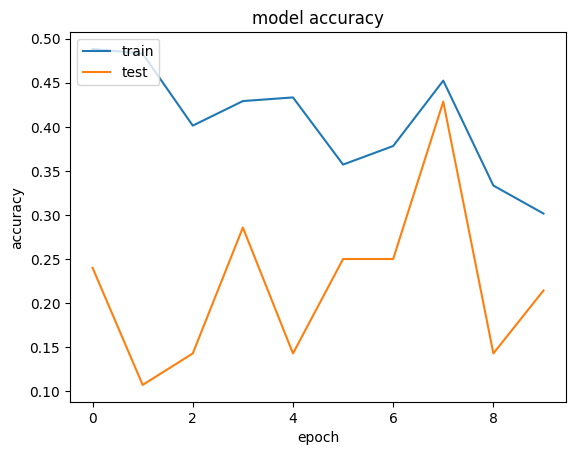

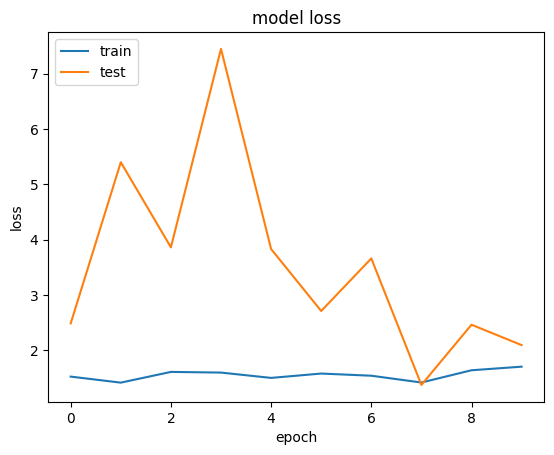

Training Avg Accuracy 0.4057912290096283
Validaiton Avg Accuracy 0.22042857483029366


In [ ]:
PlotModelHistory(model1_history)


**Transfer** Learning (**MobileNet**) with **LSTM**


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import mobilenet


In [ ]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 64

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model2.layers:
    layer.trainable = False

model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model2.add(TimeDistributed(Flatten()))

model2.add(LSTM(256))
model2.add(Dropout(0.2))

model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(5, activation='softmax'))

model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)            

<ipython-input-66-2f8f957aeb3d>:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-40-47f5ab03b91e>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
batch = 1 num_batches = 10
Folder Length = 663 batch_size = 64
# batch = 1 X =  20 Y =  120 Z =  120
 1/11 [=>............................] - ETA: 9:08 - loss: 1.6389 - categorical_accuracy: 0.2344batch = 2 num_batches = 10
Folder Length = 663 batch_size = 64
# batch = 2 X =  20 Y =  120 Z =  120
 2/11 [====>.........................] - ETA: 48s - loss: 1.6296 - categorical_accuracy: 0.2500 batch = 3 num_batches = 10
Folder Length = 663 batch_size = 64
# batch = 3 X =  20 Y =  120 Z =  120
 3/11 [=======>......................] - ETA: 1:01 - loss: 1.5839 - categorical_accuracy: 0.2656batch = 4 num_batches = 10
Folder Length = 663 batch_size = 64
# batch = 4 X =  20 Y =  120 Z =  120
 4/11 [=========>....................] - ETA: 58s - loss: 1.5575 - categorical_accuracy: 0.2852 batch = 5 num_batches = 10
Folder Length = 663 batch_size = 64
# batch = 5 X =  20 Y =  120 Z =  120
 5/11 [============>.................] - ETA: 50s - loss: 1.5346 - categorical_accuracy: 0.3063batch

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


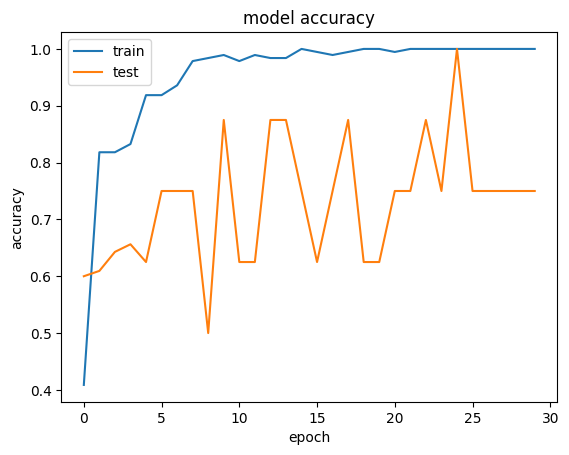

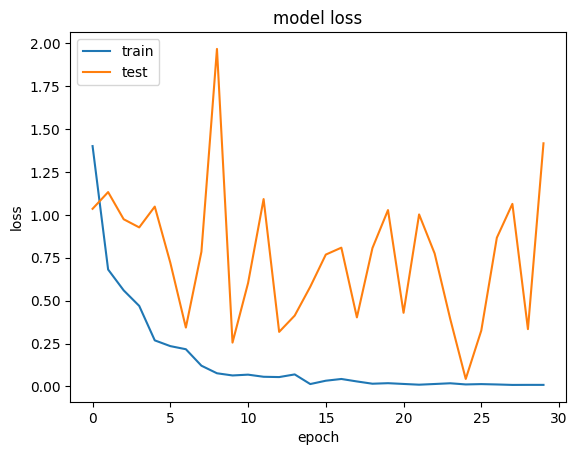

Training Avg Accuracy 0.9503991176684697
Validaiton Avg Accuracy 0.7294494052728017


In [82]:
PlotModelHistory(model2_history)

**Transfer** Learning (**MobileNet**) with ***GRU***

In [ ]:
from keras.layers import GRU


model3 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_gru")

for layer in model2.layers:
    layer.trainable = False

model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model3.add(TimeDistributed(Flatten()))

model3.add(GRU(256))  # Replacing LSTM with GRU
model3.add(Dropout(0.2))

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)            

<ipython-input-74-a725742c6e7b>:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-40-47f5ab03b91e>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
batch = 23 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 23 X =  20 Y =  120 Z =  120
 1/11 [=>............................] - ETA: 50s - loss: 1.5179 - categorical_accuracy: 0.4706batch = 24 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 24 X =  20 Y =  120 Z =  120
 2/11 [====>.........................] - ETA: 17s - loss: 1.7909 - categorical_accuracy: 0.3529batch = 25 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 25 X =  20 Y =  120 Z =  120
 3/11 [=======>......................] - ETA: 14s - loss: 1.8079 - categorical_accuracy: 0.2941batch = 26 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 26 X =  20 Y =  120 Z =  120
 4/11 [=========>....................] - ETA: 13s - loss: 1.7970 - categorical_accuracy: 0.2941batch = 27 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 27 X =  20 Y =  120 Z =  120
 5/11 [============>.................] - ETA: 12s - loss: 1.7288 - categorical_accuracy: 0.294

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


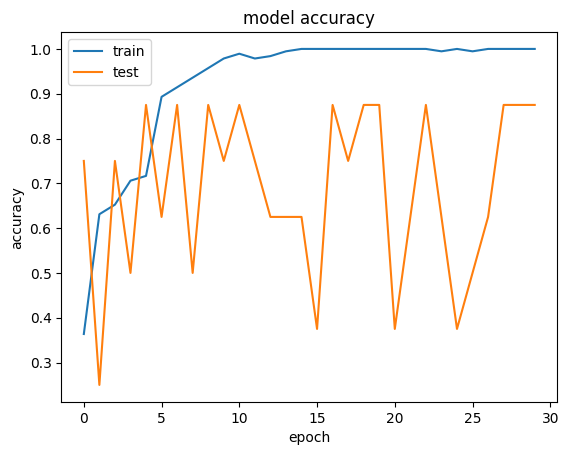

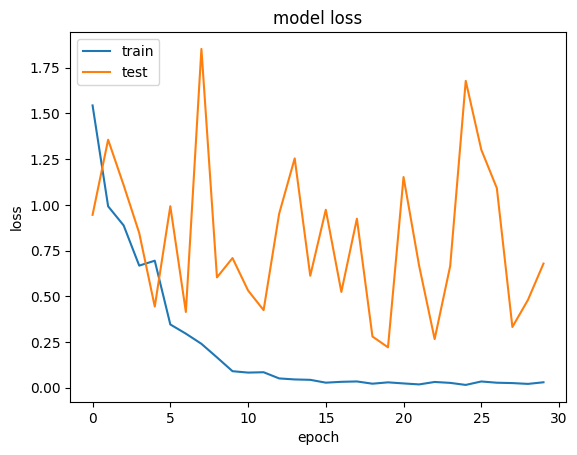

Training Avg Accuracy 0.9228163957595825
Validaiton Avg Accuracy 0.6875


In [75]:
PlotModelHistory(model3_history)

**Transfer** Learning (**MobileNet With All Weights**) with ***GRU***

In [77]:
from keras.applications import MobileNetV2
from keras.layers import LSTM, Dense

image_size = (120, 120)
n_frames = 20

# MobileNetV2 with all weights
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

model4 = Sequential(name="mobilenet_lstm")
model4.add(TimeDistributed(mobilenet, input_shape=(n_frames, image_size[0], image_size[1], 3)))
model4.add(TimeDistributed(Flatten()))
model4.add(LSTM(128))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = optimizers.Adam()
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

# Train the model
model4_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                                    callbacks=callbacks_list, validation_data=val_generator,
                                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 20, 4, 4, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 20, 20480)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)               10551808  
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 5)              

<ipython-input-77-8ec3401e458f>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-40-47f5ab03b91e>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
batch = 10 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 10 X =  20 Y =  120 Z =  120
 1/11 [=>............................] - ETA: 17s - loss: 1.6036 - categorical_accuracy: 0.3529batch = 11 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 11 X =  20 Y =  120 Z =  120
 2/11 [====>.........................] - ETA: 26s - loss: 1.6630 - categorical_accuracy: 0.4118batch = 12 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 12 X =  20 Y =  120 Z =  120
 3/11 [=======>......................] - ETA: 21s - loss: 1.6312 - categorical_accuracy: 0.4118batch = 13 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 13 X =  20 Y =  120 Z =  120
 4/11 [=========>....................] - ETA: 17s - loss: 1.6934 - categorical_accuracy: 0.3824batch = 14 num_batches = 39
Folder Length = 663 batch_size = 17
# batch = 14 X =  20 Y =  120 Z =  120
 5/11 [============>.................] - ETA: 14s - loss: 1.6723 - categorical_accuracy: 0.364

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


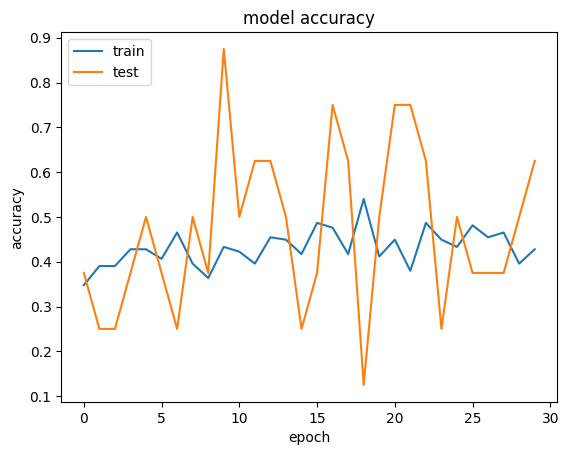

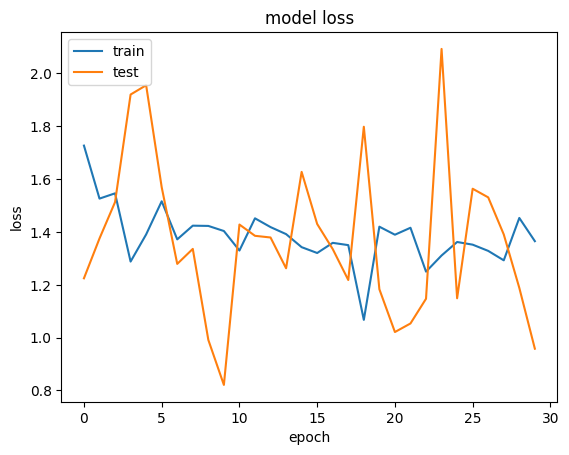

Training Avg Accuracy 0.4313725461562475
Validaiton Avg Accuracy 0.4708333333333333


In [78]:
PlotModelHistory(model4_history)